In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import numpy as np
from sklearn.model_selection import train_test_split


In [2]:
# REFERENCE:
# https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [3]:
train_data_set = np.load("fashion_train.npy")
test_data_set = np.load("fashion_test.npy")


# We have 10000 images in the training set
len(train_data_set)

# To find classification for each element, the last value in the set is:
# 0 for T-shirt/top
# 1 for Trousers
# 2 for Pullover
# 3 for Dress
# 4 for Shirt
len(train_data_set[0])

785

In [4]:
# We need to clean the array, as the last value is the classification. Let's first save these separately.

train_classes = []

for i in range(len(train_data_set)):
    train_classes.append(train_data_set[i][784])
      
train_classes = np.array(train_classes)
#train_classes = train_classes.reshape(-1, 1)


test_classes = []

for i in range(len(test_data_set)):
    test_classes.append(test_data_set[i][784])
      
test_classes = np.array(test_classes)
#test_classes = test_classes.reshape(-1, 1)

In [5]:
# Now we can delete the last element and have a cleaned training set that we can work with.

cleaned_train_set = np.empty((len(train_data_set), 784), dtype=np.uint8)

for i in range(len(train_data_set)):
    temp = np.delete(train_data_set[i], 784)
    cleaned_train_set[i] = temp
    
    
cleaned_test_set = np.empty((len(test_data_set), 784), dtype=np.uint8)

for i in range(len(test_data_set)):
    temp = np.delete(test_data_set[i], 784)
    cleaned_test_set[i] = temp

In [6]:
# We reshape it so that the 1D array becomes a 2D 28x28 array. 
# We also need to save the number of channels in the second value for our CNN to work.
#cleaned_train_set_reshaped = cleaned_train_set.reshape(-1, 28, 28)
#cleaned_test_set_reshaped = cleaned_test_set.reshape(-1, 28, 28)

In [7]:
# We normalise the pixel values of the images to range from 0 to 1
X_train = cleaned_train_set/255
X_test = cleaned_test_set/255

# Not used at the moment, but if we need to reshape our y to be (n, 1)
y_train = train_classes.reshape(-1, 1)
y_test = test_classes.reshape(-1, 1)

# Standardize the data
scaler = StandardScaler()
stand_X_train = scaler.fit_transform(X_train)

# Also apply standardization to test data
stand_X_test = scaler.transform(X_test)


In [8]:
# Time to find the right number of PCA components, as we want the components to explain 90% of the variance in total.
pca_components = len(stand_X_train[0])
pca = PCA(pca_components)
pca_train_result = pca.fit_transform(stand_X_train)


pca_sum_list = [pca.explained_variance_ratio_[0]]
i = 1

while sum(pca_sum_list) < 0.90:
    pca_sum_list.append(pca.explained_variance_ratio_[0+i])
    i += 1

In [9]:
# Print the shapes and explained variance ratio
pca_components = len(pca_sum_list)
pca = PCA(pca_components)
pca_train_result = pca.fit_transform(stand_X_train)
pca_test_result = pca.transform(stand_X_test)

print("Transformed data shape:", pca_train_result.shape)
print("Explained variance ratio:", pca.explained_variance_ratio_[:50])

print(f'The sum of our PCA\'s explained variance: {sum(pca.explained_variance_ratio_)}')

Transformed data shape: (10000, 112)
Explained variance ratio: [0.22645698 0.13673557 0.06381166 0.05046707 0.03064291 0.02924805
 0.02197067 0.01880203 0.0147053  0.01416444 0.01298674 0.01232636
 0.01005118 0.00914286 0.00886118 0.00844979 0.00800824 0.0074046
 0.0071842  0.00678097 0.00637763 0.00625898 0.0059261  0.00557587
 0.00524909 0.00501018 0.00489192 0.0047749  0.00451686 0.00424941
 0.00419099 0.00403955 0.00393599 0.00388444 0.00379559 0.00362945
 0.00357774 0.00351893 0.0033366  0.00324689 0.00315796 0.00312241
 0.00298241 0.00291242 0.00277143 0.00273707 0.00264378 0.00258011
 0.00245684 0.00243528]
The sum of our PCA's explained variance: 0.9001329354556716


In [10]:
# Load training data
X, y = pca_train_result, train_classes
X_test, y_test = pca_test_result, test_classes
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25)

In [11]:
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Assuming the labels are available as y_train and y_val
# Convert labels to PyTorch tensors
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create TensorDataset
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FFNN, self).__init__()
        # Simple 3-layer FFNN
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # ReLU activation
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation on the output (logits for classification)
        return x

# Initialize model
input_dim = pca_train_result.shape[1]  # Number of PCA components
hidden_dim = 256  # Number of hidden neurons
output_dim = 5 # Number of classes (for classification)

model = FFNN(input_dim, hidden_dim, output_dim)
print(model)

FFNN(
  (fc1): Linear(in_features=112, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=5, bias=True)
)


In [13]:
criterion = nn.CrossEntropyLoss()  # Use for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
total_epochs = 100
patience = 5
patience_reactions = ('','Getting a little impatient here','Seriously, getting rather impatient','I am getting seriously impatient...', 'Now you\'re really testing me!', 'My patience is done. Terminating')
patience_counter = 0

for epoch in range(total_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for batch in train_loader:
        inputs, labels = batch
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Zero gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{total_epochs}], Loss: {running_loss / len(train_loader):.4f}")
    if running_loss/len(train_loader) < 0.1:
        patience_counter += 1
        print(patience_reactions[patience_counter])
    if patience_counter == patience:
        break
    
    
print("Finished training.")


Epoch [1/100], Loss: 0.3520
Epoch [2/100], Loss: 0.3041
Epoch [3/100], Loss: 0.2678
Epoch [4/100], Loss: 0.2410
Epoch [5/100], Loss: 0.2074
Epoch [6/100], Loss: 0.1813
Epoch [7/100], Loss: 0.1558
Epoch [8/100], Loss: 0.1381
Epoch [9/100], Loss: 0.1193
Epoch [10/100], Loss: 0.1095
Epoch [11/100], Loss: 0.0887
Getting a little impatient here
Epoch [12/100], Loss: 0.0646
Seriously, getting rather impatient
Epoch [13/100], Loss: 0.0567
I am getting seriously impatient...
Epoch [14/100], Loss: 0.0461
Now you're really testing me!
Epoch [15/100], Loss: 0.0539
My patience is done. Terminating
Finished training.


In [16]:
classes = ('t-shirt/top', 'trousers', 'pullovers', 'dresses', 'shirts')

#### Class accuracy for validation data

In [17]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


combined_accuracy = 0.0
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    combined_accuracy += accuracy
    
combined_accuracy = combined_accuracy/5

print(f'The combined accuracy of our model for validation data is: {combined_accuracy:.1f}%')

Accuracy for class: t-shirt/top is 84.7 %
Accuracy for class: trousers is 96.6 %
Accuracy for class: pullovers is 83.2 %
Accuracy for class: dresses is 88.8 %
Accuracy for class: shirts is 65.5 %
The combined accuracy of our model for validation data is: 83.8%


#### Class accuracy for test data

In [18]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


combined_accuracy = 0.0
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    combined_accuracy += accuracy
    
    
combined_accuracy = combined_accuracy/5

print(f'The combined accuracy of our model for test data is: {combined_accuracy:.1f}%')

Accuracy for class: t-shirt/top is 86.2 %
Accuracy for class: trousers is 95.9 %
Accuracy for class: pullovers is 83.8 %
Accuracy for class: dresses is 91.0 %
Accuracy for class: shirts is 67.3 %
The combined accuracy of our model for test data is: 84.8%


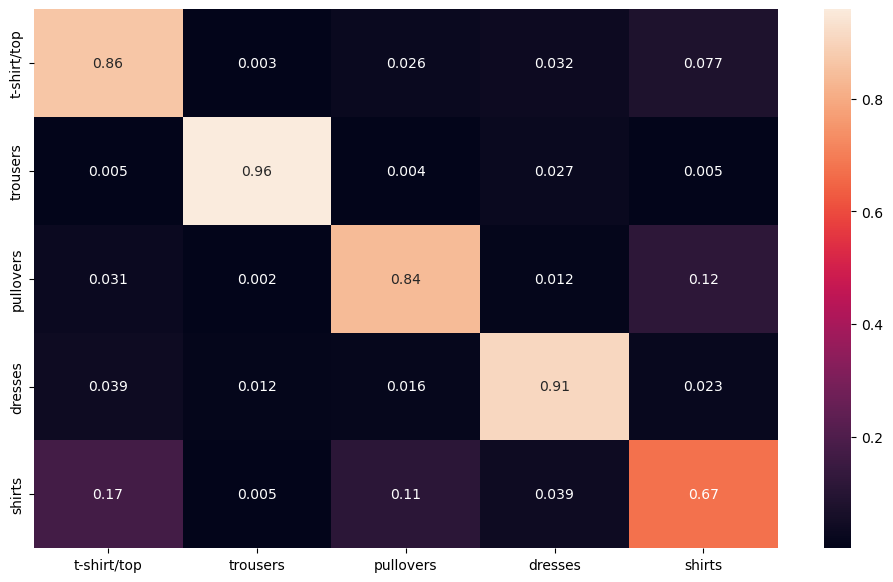

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth


# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')